# Python基礎・データサイエンス
### 【5】遺伝的アルゴリズムとは、システム内で⾃然淘汰に類似するシュミレーションを⾏い、最適解を近似的に求めるアルゴリズムである。このアルゴリズムを⽤いて、巡回セールスマン問題を解くプログラムをPythonで実装してみよう。

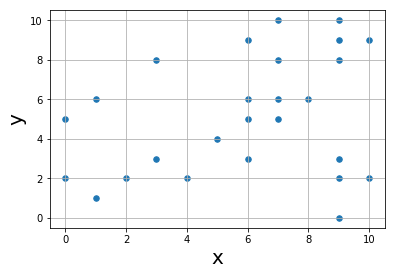

In [70]:
# 座標平面上の 0 ≦ x ≦ 10 , 0 ≦ y ≦10 の領域の格子点上にランダムにA~Zまでの26個の点を配置し、結果を可視化して保存せよ
#（但し、全ての点の座標はそれぞれ異なるものとする）。
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt

arr = np.empty((26,2)) # row,column
point = list(range(0, 121, 1))

for num in range(0,26):
    p = point.pop(rd.randint(0, len(point)-1))
    arr[num,0] = p // 11
    arr[num,1] = p % 11

plt.grid(True)
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
plt.scatter(arr[:,0], arr[:,1], s=30)

In [71]:
# ② ①で作成した点の全てのペアについて距離を計算し、DataFrameにまとめてcsv形式で保存せよ。
distance = []  # 距離の組み合わせを入れるリスト
M=[i for i in range(26)]
for i in range(25):
    for i in range(13):
        a = np.array([arr[M[0+i],0], arr[M[0+i],1]])
        b = np.array([arr[M[-1-i],0], arr[M[-1-i],1]])
        dist = np.linalg.norm(a-b)
        
        distance.append([M[0+i], a, M[-1-i], b, dist])
        M = M[:1] + M[2:] + M[1:2] # 先頭を固定して１つずつずらす
    
# CSV ファイル (employee.csv) として出力
feature = ["point1", "a", "point2", "b", "distance"]
df = pd.DataFrame(distance, columns=feature)
df.to_csv("distance.csv")

In [72]:
# 準備で作成した全ての点を⼀度だけ通る、最短の経路を⾒つけたい。この問題は、NP困難と呼ばれる最適化問題の典型的な例で、全てのパターンを網羅的に計算すると天⽂学的な計算量を要する。
# ③ 全てのパターンを計算するのにどれほどの時間がかかるか、Pythonを⽤いて試算してみよ（⼀つの経路について距離を計算するのに0.01秒かかるものせよ）。
import math

print(math.factorial(26) * 0.01, " 秒" )

4.0329146112660566e+24  秒


In [309]:
# ④ 下記の流れに沿って、遺伝的アルゴリズムを⽤いて近似解を⽤いるスクリプトを実装せよ。
# 4-1. 初期集団の⽣成
# ランダムにＣ-Ａ-Ｄ-Ｂ… Ｂ-Ｄ-Ｃ-Ａ… Ａ-Ｃ-Ｄ-Ｂ… などと、決められた数の親を作成する
def creat_first_data():
    original = list(range(0, 26, 1))
    data = []
    for i in range(10): # 最初のデータ数
        data.append(rd.sample(original, len(original)))
    return data

In [291]:
# 4-2. 適応度の評価
# 上で作成された巡回ルートそれぞれの距離を算出する
def evaluate_select(test_data, better_sum, better_sample, repeat):
    num = 0
    for l in range(len(test_data)): #sample分
        sum = 0.0
        for i in range(25):
            a = df.loc[(df['point1'] == test_data[l][i]) & (df['point2'] == test_data[l][i+1]), 'distance']
            b = df.loc[(df['point1'] == test_data[l][i+1]) & (df['point2'] == test_data[l][i]), 'distance']
            if a.count() != 0:
                sum += float(a)
            else:
                sum += float(b)
# 4-3. 選択
# 上で算出された巡回ルートの距離が短いものほど確率的に選択される可能性が高く、
# 距離が長いものほど選択される可能性が少なくなるようにした上で、自然淘汰を模した選択を実施する
        if float(better_sum[0]) > sum:
            better_sample = list(test_data[l])
            better_sum.insert(0,sum)
            num += 1
            repeat = 0
    if num == 0:
        repeat += 1
    return list(better_sum), better_sample, repeat

In [302]:
# 4-4. 交叉
# 上で選択されたものと「似ている」子供を、選ばれた親から作成する（例えば、親と半分以上の
# 順番を共有しているパターンを子供とする、など）
def create_child(parent):
    child = list(parent)
    i = rd.randint(0, 12) # 変更する要素が何番目からか
    n = rd.randint(1, 13) # 順番を共有しない要素数
    child[i:i+n] = rd.sample(parent[i:i+n],n)
    return child

In [313]:
# 4-5. 突然変異
# 上で作成されたルートの内、いくつかの順番をランダムに変える
def mutate(child):
    test_data = []
    for i in range(10): # データ数
        for l in range(rd.randint(1, 5)): # 順番を入れ替える回数
            a = b = 0
            while a == b:
                a = rd.randint(0, 25)
                b = rd.randint(0, 25)
            child[a], child[b] = child[b], child[a]
        test_data.append(list(child))
    return test_data

In [314]:
# 4-6. 繰り返し／終了条件判定
# 4-5で得られたパターンを用いて4-2以降のプロセスを繰り返し、⼀定期間最良のパターンが
# 更新されなかった場合に停止して そのパターンを結果として出力する

first_loop = True
while True:
    if first_loop:
        print('***** FIRST LOOP ******')
# 4-1
        first_data = creat_first_data()
# 4-2,4-3
        e_s = evaluate_select(first_data, [999.9], [], 0)
# first loop
        first_loop = False
        update_history = []
    else:
        print('***** ', ' LOOP ******')
# 4-2,4-3
        e_s = evaluate_select(test_data, list(e_s[0]), list(e_s[1]), e_s[2])
# 4-4
    child_sample = create_child(e_s[1])
# 4-5
    test_data = mutate(child_sample)
# print
    print(e_s)
# 4-6 終了条件 10回同じ最短距離が算出されたら終了
    if e_s[2] > 8:
        print('**** EXIT ****')
        print('shortest distance:', e_s[0][0])
        break

***** FIRST LOOP ******
([118.79987788553767, 132.85856650811434, 146.54792192590122, 999.9], [23, 1, 5, 0, 4, 18, 3, 13, 12, 24, 8, 17, 11, 2, 19, 15, 21, 7, 14, 9, 25, 6, 16, 22, 20, 10], 0)
*****   LOOP ******
([114.82855640549909, 116.89364558434374, 118.79987788553767, 132.85856650811434, 146.54792192590122, 999.9], [9, 20, 21, 2, 18, 23, 13, 10, 15, 17, 8, 14, 4, 7, 11, 5, 0, 19, 3, 25, 6, 24, 12, 1, 22, 16], 0)
*****   LOOP ******
([110.61149952713617, 112.88903056002137, 114.82855640549909, 116.89364558434374, 118.79987788553767, 132.85856650811434, 146.54792192590122, 999.9], [0, 6, 5, 11, 4, 23, 10, 14, 9, 20, 18, 19, 17, 8, 21, 7, 1, 13, 24, 15, 3, 25, 2, 22, 16, 12], 0)
*****   LOOP ******
([104.03475176207522, 110.61149952713617, 112.88903056002137, 114.82855640549909, 116.89364558434374, 118.79987788553767, 132.85856650811434, 146.54792192590122, 999.9], [14, 6, 5, 11, 10, 4, 9, 2, 16, 23, 1, 19, 17, 8, 13, 18, 7, 21, 24, 15, 3, 25, 20, 22, 0, 12], 0)
*****   LOOP ******
